# Benchmark Model

We preprocessesd our data using a Tokenizer and Stemmer, then engineered features using TF-IDF Vectorizer. The processed data is used to train to a LogisticRegression classifier. 

## Table of Contents

1. [Collecting Tweets](01-Gathering-Data.ipynb)
1. [Feature Engineering with TF-IDF](02-Feature-Engineering.ipynb)
1. [Benchmark Model](03-Benchmark-Model.ipynb)
1. [Feature Engineering & Model Tuning with Doc2Vec](04-Model-Tuning.ipynb)
1. [Making Predictions on Test Data](05-Making-Predictions.ipynb)
1. [Visualizing a Disaster Event](06-Time-Series-Analysis.ipynb)

### Import Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

import time
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from pactools.grid_search import GridSearchCVProgressBar

# preprocessing, data cleaning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# classification models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [7]:
dtweets = pd.read_csv('../data/datasets/socialmedia-disaster-tweets-DFE.csv', encoding = 'ISO-8859-1')

In [8]:
dtweets['label'] = dtweets.choose_one.apply(lambda x: 1 if x == "Relevant" else 0)

### Build list of stop words

In [10]:
custom_stop_words = set(ENGLISH_STOP_WORDS)
custom_stop_words.update(['http', 'www', 'twitter', 'reddit', 'com', 'amp', 'x200b', 
                          'deleted', 'en', 'wikipedia', 'org', 
                          'youtube', 'comment', 'rt', 'https'])

### TF-IDF Vectorizer

In [14]:
dtweets_class = dtweets[['text','label']]

tfidf = TfidfVectorizer(stop_words=custom_stop_words, 
                        ngram_range=(2,2))
tfidf_trans = tfidf.fit_transform(dtweets['text'])

X_tfidf = pd.DataFrame(tfidf_trans.todense(), columns = tfidf.get_feature_names())

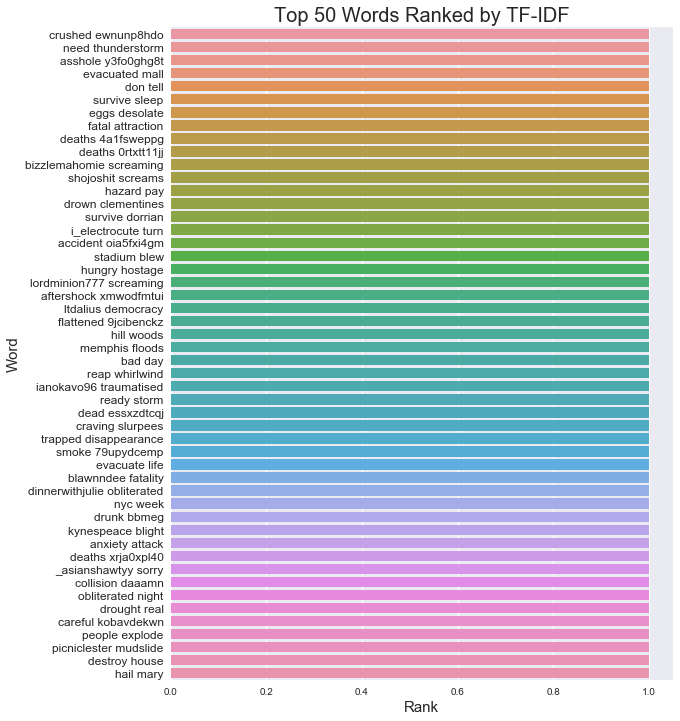

In [15]:
top_n = 50
top_features = X_tfidf.max().sort_values(ascending = False)[:top_n]

plt.figure(figsize = (9, 12))
plt.title(f'Top {top_n} Words Ranked by TF-IDF', fontsize = 20)
plt.ylabel('Word', fontsize = 15)
plt.xlabel('Rank', fontsize = 15)
plt.yticks(fontsize = 12)
sns.barplot(top_features.values, top_features.index)
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_cvec,dtweets['label'], test_size = 0.25, random_state = 42)

X1_train, X1_test, y1_train, y1_test = train_test_split(X_tfidf,dtweets['label'], test_size = 0.25, random_state = 42)

In [7]:
classifier_models = {
    'LogisticRegression' : LogisticRegression()
#    'KNN': KNeighborsClassifier(n_neighbors=2) 
#    'NaiveBayes' : MultinomialNB()
#    'DecisionTree' : DecisionTreeClassifier(random_state = 42), 
#    'BaggedDecisionTree' : BaggingClassifier(random_state = 42),
#    'RandomForest' : RandomForestClassifier(random_state = 42), 
#    'ExtraTrees': ExtraTreesClassifier(random_state = 42), 
#    'AdaBoost' : AdaBoostClassifier(random_state=42), 
#     'GradientBoosting' : GradientBoostingClassifier(random_state = 42),
#    'SVM' : SVC()
}

In [8]:
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [1]:
classifier_model_params = {
    'LogisticRegression' : {
        'max_iter': [100, 300, 600],
        'penalty' : ['l1','l2'],
        'C' : [0.1, 1, 10, 100],
        'solver': ['liblinear','newton-cg', 'sag', 'saga' ,'lbfgs' ]},
#    'KNN' : {
#        'n_neighbors' : [2] },
#    'NaiveBayes' : {
#        'alpha' : [.5, 1, 2]}
}

In [42]:
def gridsearch_summary(X_train, X_test, y_train, y_test, model_name, model, model_params, problem = 'classification'):
    '''
    Arguments:
    X_train, X_test, y_train, y_test : vectorized train test split of X and y
    model_name : str name of model
    model : model constructor
        example: 'LogisticRegression' : LogisticRegression()
    model_params : dictionary of param_grids for GridSearch
        example: 'LogisticRegression' : {
                      'penalty' : ['l1', 'l2'],
                      'C' : [.1, 1, 10] }
    problem : str of problem type: 'classification' or 'regression'
    
    Return:
    summary_df : a single row DataFrame containing the GridSearch model and its 
              best model, predictions, and scores.
    '''   
    problem = problem.lower()
    
    if problem != 'regression' and problem != 'classification':
        print('Invalid problem type. Try "regression" or "classification"')
        return

    summary = {}

    # Track progress
    print(f'Fitting {model_name}')

    # GridSearch
    gs = GridSearchCVProgressBar(model, model_params, cv = 5)
    gs.fit(X_train, y_train)

    # Make predictions
    y_train_pred = gs.best_estimator_.predict(X_train)
    y_test_pred = gs.best_estimator_.predict(X_test)

    # Build summary
    summary['Model Name'] = model_name
    summary['Train Pred'] = y_train_pred
    summary['Test Pred'] = y_test_pred
    summary['Best Score'] = gs.best_score_
    summary['Best Params'] = gs.best_params_
    summary['Best Estimator'] = gs.best_estimator_
    summary['Grid Search Model'] = gs

    if problem == 'regression':
        summary['Train Score'] = r2_score(y_train, y_train_pred)
        summary['Test Score'] = r2_score(y_test, y_test_pred)
    elif problem == 'classification':
        summary['Train Score'] = accuracy_score(y_train, y_train_pred)
        summary['Test Score'] = accuracy_score(y_test, y_test_pred)
    
    # Construct output dataframe 
    summary_df = pd.DataFrame([summary])

    # Rearrange columns
    summary_df = summary_df[['Model Name', 'Best Params', 'Best Score', 'Best Estimator',
                             'Train Score', 'Test Score', 'Train Pred', 'Test Pred', 'Grid Search Model']]
        
    return summary_df

In [43]:
t0 = time.time()
gs_tfidf_summaries = pd.DataFrame()

for model_name, model in classifier_models.items():
    gs_tfidf_summaries = gs_tfidf_summaries.append(gridsearch_summary(X_train, X_test, y_train, y_test, 
                                                                       model_name, model,
                                                                       classifier_model_params[model_name]), 
                                                                       ignore_index = True)
time.time() - t0

Fitting NaiveBayes
[........................................] 100% | 152.40 sec | GridSearchCV 


158.0271701812744

In [33]:
# Logistic Regression, overfitting, not a good method for this problem?
gs_tfidf_summaries[['Model Name', 'Best Params', 'Best Score', 'Train Score', 'Test Score']]

,Model Name,Best Params,Best Score,Train Score,Test Score
0,LogisticRegression,"{'C': 1, 'penalty': 'l2'}",0.805075,0.967513,0.799191


In [39]:
# Naive Bayes
gs_tfidf_summaries[['Model Name', 'Best Params', 'Best Score', 'Train Score', 'Test Score']]

,Model Name,Best Params,Best Score,Train Score,Test Score
0,KNN,{'n_neighbors': 2},0.69094,0.785338,0.680765
